In [1]:
%load_ext autoreload
%autoreload 2

from epsilon_transformers.persistence import S3Persister, HackyPersister
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.process.processes import RRXOR, TransitionMatrixGHMM, ZeroOneR, Mess3
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs

import numpy as np
import torch
import plotly.express as px
import pathlib

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

ModuleNotFoundError: No module named 'epsilon_transformers.training.configs'

In [2]:
from scipy import linalg

rr = ZeroOneR()
T = rr.transition_matrix
T = T.sum(axis=0)

# eigenvalues/eigenvectors
Rval, Rvec = linalg.eig(T)
Lval, Lvec = linalg.eig(T.T)

# get the vecs with eigenvalue 1
Rvec = Rvec[:, np.isclose(Rval, 1)]
Lvec = Lvec[:, np.isclose(Lval, 1)].T

Lvec = Lvec/Lvec.sum()

# check that these are actually eigenvectors
assert np.allclose(Lvec @ T, Lvec)
assert np.allclose(T @ Rvec, Rvec)

inner_product = Lvec.real @ Rvec.real
print('inner_product', inner_product)
print('Lvec', np.array2string(Lvec, precision=2, suppress_small=True))
print('Rvec', np.array2string(Rvec.T, precision=2, suppress_small=True))
print('Lvec / inner_product', np.array2string(Lvec / inner_product, precision=2, suppress_small=True))
print('Lvec sum to 1', np.array2string(Lvec.real / Lvec.real.sum(), precision=2, suppress_small=True))

inner_product [[-0.57735027]]
Lvec [[0.33-0.j 0.33-0.j 0.33-0.j]]
Rvec [[-0.58+0.j -0.58+0.j -0.58+0.j]]
Lvec / inner_product [[-0.58-0.j -0.58-0.j -0.58-0.j]]
Lvec sum to 1 [[0.33 0.33 0.33]]


In [3]:
(Lvec @ np.identity(3) @ Rvec)

array([[-0.57735027+0.j]])

In [4]:
rr = ZeroOneR()
T = rr.transition_matrix
rr = TransitionMatrixGHMM(T)

pi = rr.steady_state_vector
ones = rr.right_eigenvector
emission_probs = (pi @ rr.transition_matrices @ ones) / (pi @ ones)
emission_probs.squeeze()

emission, next_latent = rr._sample_emission_and_next_latent(latent_state=np.array([[1, 0, 0]]))
print(emission)
print(next_latent)

list(rr.yield_emissions(10))

0
[[0. 1. 0.]]


[0, 0, 1, 1, 0, 1, 0, 0, 1, 0]

In [30]:
def create_fanizza_transition_matrix(alpha: float, lamb: float) -> np.ndarray:
    # Calculate intermediate values
    a_la = (1 - lamb * np.cos(alpha) + lamb * np.sin(alpha)) / (1 - 2 * lamb * np.cos(alpha) + lamb**2)
    b_la = (1 - lamb * np.cos(alpha) - lamb * np.sin(alpha)) / (1 - 2 * lamb * np.cos(alpha) + lamb**2)

    # Define tau
    tau = np.ones(4)

    # Define the reset distribution pi0
    pi0 = np.array([1 - (2 / (1 - lamb) - a_la - b_la) / 4, 1 / (2 * (1 - lamb)), -a_la / 4, -b_la / 4])

    # Define w
    w = np.array([1, 1 - lamb, 1 + lamb * (np.sin(alpha) - np.cos(alpha)), 1 - lamb * (np.sin(alpha) + np.cos(alpha))])

    # Create Da
    Da = np.outer(w, pi0)

    # Create Db (with the sine sign error fixed)
    Db = lamb * np.array([
        [0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, np.cos(alpha), -np.sin(alpha)],
        [0, 0, np.sin(alpha), np.cos(alpha)]
    ])

    # Create the transition matrix T
    T = np.zeros((2, 4, 4))
    T[0] = Da
    T[1] = Db

    # Verify that T @ tau = tau (stochasticity condition)
    assert np.allclose(T[0] @ tau + T[1] @ tau, tau), "Stochasticity condition not met"

    return T

In [97]:
import numpy as np

def create_G_matrices(alpha, beta, gamma):
    # Create a 4x3x3 array filled with zeros
    G = np.zeros((4, 3, 3))
    
    # Common elements
    common_diag = 1/4
    middle_diag = (alpha**2 - beta**2) * gamma**2
    off_diag = 2 * alpha * beta * gamma**2
    
    # G^(0)
    G[0] = np.array([
        [common_diag, 0, off_diag],
        [0, middle_diag, 0],
        [off_diag, 0, common_diag]
    ])
    
    # G^(1)
    G[1] = np.array([
        [common_diag, 0, -off_diag],
        [0, middle_diag, 0],
        [-off_diag, 0, common_diag]
    ])
    
    # G^(2)
    G[2] = np.array([
        [common_diag, off_diag, 0],
        [off_diag, common_diag, 0],
        [0, 0, middle_diag]
    ])
    
    # G^(3)
    G[3] = np.array([
        [common_diag, -off_diag, 0],
        [-off_diag, common_diag, 0],
        [0, 0, middle_diag]
    ])
    
    return G



(4, 3, 3)


array([[1.        , 0.        , 0.        ],
       [0.        , 0.02702703, 0.        ],
       [0.        , 0.        , 0.02702703]])

[[3.]
 [0.]
 [0.]] [[1. 0. 0.]]


In [123]:
# Example usage:
alpha = 1.
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
import pandas as pd

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))
n_frames = 100

# Function to update the plot for each frame
def update(frame):
    beta = np.linspace(1, 8, n_frames)[frame]
    gamma = 1/(2*np.sqrt(alpha**2+beta**2))
    G = create_G_matrices(alpha, beta, gamma)
    
    G_process = TransitionMatrixGHMM(G)
    G_process.name = "G"
    MSP = G_process.derive_mixed_state_presentation(depth=8)
    beliefs = np.array(MSP.belief_states).squeeze()
    unique_beliefs = np.unique(np.round(beliefs, decimals=5), axis=0)
    
    # Create a DataFrame
    df = pd.DataFrame(unique_beliefs, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])
    df['distance'] = 1-np.sqrt(df['Dimension 2']**2 + df['Dimension 3']**2)

    # Clear previous plot
    ax.clear()
    
    # Create the scatter plot
    scatter = ax.scatter(df['Dimension 2'], df['Dimension 3'], 
                         c=df['distance'], cmap='plasma', s=1)
    
    # Set plot properties
    ax.set_xlim(-.5, .5)
    ax.set_ylim(-.5, .5)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('black')
    
    # Add title
    ax.set_title(f'Beta: {beta:.2f}', color='white')

    return scatter,

# Create the animation
anim = FuncAnimation(fig, update, frames=n_frames, interval=200, blit=True)

# Set figure properties
fig.patch.set_facecolor('black')

# Save as GIF
writer = PillowWriter(fps=20)
anim.save('quantum_animation2.gif', writer=writer)

plt.close(fig)

print("Animation saved as 'quantum_animation.gif'")


Animation saved as 'quantum_animation.gif'


In [6]:
MSP = F_presentation.derive_mixed_state_presentation(depth=10)

(2047, 4)


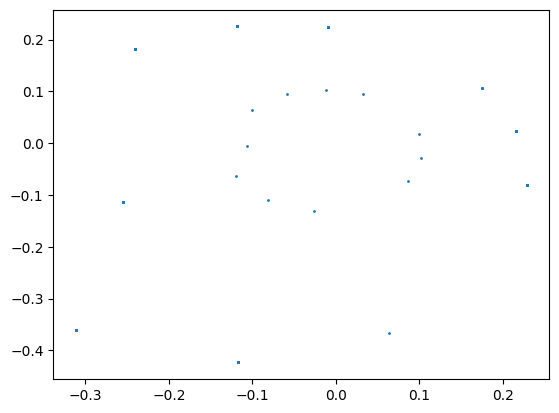

In [7]:
beliefs = np.array(MSP.belief_states).squeeze()
print(beliefs.shape)
from matplotlib import pyplot as plt
plt.scatter(beliefs[:, 2], beliefs[:, 3], alpha=1, s=1)


In [8]:
T = F_presentation.transition_matrix
T = T.sum(axis=0)
Rval, Rvec = np.linalg.eig(T)
Lval, Lvec = np.linalg.eig(T.T)
right_eigenvector = Rvec[:, np.isclose(Rval, 1)]
left_eigenvector = Lvec[:, np.isclose(Lval, 1)].T
left_eigenvector = left_eigenvector/left_eigenvector.sum()
inner_product = left_eigenvector @ right_eigenvector
print('inner_product', inner_product)
print('left_eigenvector', np.array2string(left_eigenvector, precision=2, suppress_small=True))
print('right_eigenvector', np.array2string(right_eigenvector, precision=2, suppress_small=True))
print('left_eigenvector / inner_product', np.array2string(left_eigenvector / inner_product, precision=2, suppress_small=True))
print('left_eigenvector sum to 1', np.array2string(left_eigenvector / left_eigenvector.sum(), precision=2, suppress_small=True))


inner_product [[0.5+0.j]]
left_eigenvector [[ 0.19+0.j  0.92+0.j -0.11+0.j -0.01+0.j]]
right_eigenvector [[0.5+0.j]
 [0.5+0.j]
 [0.5+0.j]
 [0.5+0.j]]
left_eigenvector / inner_product [[ 0.37+0.j  1.85+0.j -0.21+0.j -0.01+0.j]]
left_eigenvector sum to 1 [[ 0.19+0.j  0.92+0.j -0.11+0.j -0.01+0.j]]


In [1]:
pi = F_presentation.steady_state_vector
ones = F_presentation.right_eigenvector
print(pi.shape)
print(ones.shape)
print(F_presentation.transition_matrices[0].shape)
depth = 10
for i in range(depth):
    for emission in range(F_presentation.vocab_len):
        next_process_state = (pi @ F_presentation.transition_matrices[emission]) / (pi @ ones)
        print(next_process_state)

NameError: name 'F_presentation' is not defined

In [10]:
N = 5  # You can adjust this value as needed

T_N = np.linalg.matrix_power(T, N)
(left_eigenvector @ T_N @ right_eigenvector)/(left_eigenvector @ right_eigenvector)

array([[1.+0.j]])

In [11]:
MSP = F_presentation.derive_mixed_state_presentation(depth=10)

In [12]:
import plotly.graph_objects as go

bs = np.array(MSP.belief_states).squeeze()

fig = go.Figure(data=[go.Scatter3d(
    x=bs[:, 0],
    y=bs[:, 1],
    z=bs[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        opacity=0.8
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title='3D Scatter Plot of Belief States'
)

fig.show()

In [13]:
# Tom's process
import numpy as np

def create_tom_transition_matrices():
    alpha = 1.
    beta = np.sqrt(51)
    s=4*alpha**2+4*beta**2;
    alpha=alpha/s**0.5;
    beta=beta/s**0.5;

    # Assert that alpha^2 + beta^2 = 1/4
    assert np.isclose(alpha**2 + beta**2, 1/4), f"alpha^2 + beta^2 should equal 1/4, but got {alpha**2 + beta**2}"

    K0 = np.array([[alpha+beta, 0], [0, alpha-beta]])
    K1 = np.array([[alpha-beta, 0], [0, alpha+beta]])
    K2 = np.array([[alpha, beta], [beta, alpha]])
    K3 = np.array([[alpha, -beta], [-beta, alpha]])

    # Stack the matrices into a 3D array
    T = np.stack([np.kron(K0, K0),
                  np.kron(K1, K1),
                  np.kron(K2, K2),
                  np.kron(K3, K3)], axis=0)

    return T

# Create Tom's transition matrices
T_tom = create_tom_transition_matrices()
print(T_tom.sum(axis=0).sum(axis=1))
# Create a GHMM object for Tom's process
tom_presentation = TransitionMatrixGHMM(T_tom)
tom_presentation.name = "Tom's Process"
import plotly.graph_objects as go

MSP_tom = tom_presentation.derive_mixed_state_presentation(depth=8)
bs_tom = np.array(MSP_tom.belief_states).squeeze()

fig = go.Figure(data=[go.Scatter3d(
    x=bs_tom[:, 1],
    y=bs_tom[:, 2],
    z=bs_tom[:, 0],
    mode='markers',
    marker=dict(
        size=1,
        opacity=1
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3'
    ),
    title="Tom's Process Mixed State Presentation",
    width=800,
    height=600
)

fig.show()



[1.         0.01923077 0.01923077 1.        ]


In [104]:
T = create_fanizza_transition_matrix(alpha=2000., lamb=.49)
F_presentation = TransitionMatrixGHMM(T)
F_presentation.name = "Fanizza"

NameError: name 'create_fanizza_transition_matrix' is not defined

In [14]:
T_tom.shape

(4, 4, 4)

In [18]:
rr = RRXOR()
T_rr = rr.transition_matrix

rr_GHMM = TransitionMatrixGHMM(T_rr)
rr_GHMM.name = "RR"
MSP_rr = rr_GHMM.derive_mixed_state_presentation(depth=8)
bs_rr = np.array(MSP_rr.belief_states).squeeze()

fig = go.Figure(data=[go.Scatter3d(
    x=bs_rr[:, 1],
    y=bs_rr[:, 2],
    z=bs_rr[:, 0],
    mode='markers',
    marker=dict(
        size=2,
        opacity=1
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3'
    ),
    title="RR XOR Mixed State Presentation",
    width=800,
    height=600
)

fig.show()


In [19]:
np.unique(bs_rr, axis=0).shape

(82, 5)

In [20]:
from sklearn.decomposition import PCA
import plotly.graph_objects as go

# Round the belief states to 5 decimal places and remove duplicates
unique_bs_rr = np.unique(np.round(bs_rr, decimals=5), axis=0)

# Perform PCA to reduce dimensionality to 3
pca = PCA(n_components=3)
bs_rr_pca = pca.fit_transform(unique_bs_rr)

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=bs_rr_pca[:, 0],
    y=bs_rr_pca[:, 1],
    z=bs_rr_pca[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        opacity=0.8,
        color=bs_rr_pca[:, 2],  # Color by the third principal component
        colorscale='Viridis',
        colorbar=dict(title="PC3")
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    title="RR XOR Mixed State Presentation (PCA 3D projection)",
    width=800,
    height=600
)

fig.show()

print(f"Original shape: {bs_rr.shape}")
print(f"Unique points shape: {unique_bs_rr.shape}")
print(f"PCA transformed shape: {bs_rr_pca.shape}")

Original shape: (351, 5)
Unique points shape: (36, 5)
PCA transformed shape: (36, 3)


In [67]:
def GPU_next_belief(belief: torch.Tensor, transition_matrix: torch.Tensor) -> torch.Tensor:

2.237136465324385

In [130]:
import torch
import numpy as np
from typing import List, Tuple

class MPSMixedStateTree:
    def __init__(self, process, depth: int, device: str = 'mps'):
        self.process = process
        self.depth = depth
        self.device = device
        self.transition_matrices = torch.tensor(process.transition_matrix, dtype=torch.float32, device=self.device)
        self.initial_belief = torch.tensor(process.steady_state_vector, dtype=torch.float32, device=self.device)
        self.paths, self.beliefs = self._compute_paths_and_beliefs()
        self.ones = torch.tensor(process.right_eigenvector, dtype=torch.float32, device=self.device)

    def _compute_paths_and_beliefs(self) -> Tuple[List[List[int]], torch.Tensor]:
        paths = []
        beliefs = [self.initial_belief]
        queue = [([], self.initial_belief)]

        while queue:
            path, belief = queue.pop(0)
            if len(path) == self.depth:
                paths.append(path)
                continue

            for emission in range(self.process.vocab_len):
                new_path = path + [emission]
                new_belief = self._update_belief(belief, emission)
                paths.append(new_path)
                beliefs.append(new_belief)
                queue.append((new_path, new_belief))

        return paths, torch.stack(beliefs)

    def _update_belief(self, belief: torch.Tensor, emission: int) -> torch.Tensor:
        numerator = belief @ self.transition_matrices[emission]
        denominator = numerator.sum()
        return numerator / denominator

    def get_unique_beliefs(self, decimals: int = 5) -> torch.Tensor:
        return torch.unique(self.beliefs.round(decimals=decimals), dim=0)

# Modify the update function to use MPSMixedStateTree
def update(frame):
    beta = torch.linspace(1, 8, n_frames, device=device)[frame]
    gamma = 1/(2*torch.sqrt(alpha**2+beta**2))
    G = create_G_matrices(alpha, beta, gamma)
    
    G_process = TransitionMatrixGHMM(G)
    G_process.name = "G"
    
    mps_msp = MPSMixedStateTree(G_process, depth=8, device=device)
    unique_beliefs = mps_msp.get_unique_beliefs(decimals=5)
    
    # Create a DataFrame-like structure using torch tensors
    df = {
        'Dimension 1': unique_beliefs[:, 0],
        'Dimension 2': unique_beliefs[:, 1],
        'Dimension 3': unique_beliefs[:, 2],
    }
    df['distance'] = 1 - torch.sqrt(df['Dimension 2']**2 + df['Dimension 3']**2)

    # Clear previous plot
    ax.clear()
    
    # Create the scatter plot
    scatter = ax.scatter(df['Dimension 2'].cpu(), df['Dimension 3'].cpu(), 
                         c=df['distance'].cpu(), cmap='plasma', s=1)
    
    # Set plot properties
    ax.set_xlim(-.5, .5)
    ax.set_ylim(-.5, .5)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('black')
    
    # Add title
    ax.set_title(f'Beta: {beta.item():.2f}', color='white')

    return scatter,

device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(device)
n_frames = 1
alpha = torch.tensor(2000., device=device)

# Create the animation
anim = FuncAnimation(fig, update, frames=n_frames, interval=200, blit=True)

# Set figure properties
fig.patch.set_facecolor('black')

# Save as GIF
writer = PillowWriter(fps=20)
anim.save('quantum_animation2.gif', writer=writer)

plt.close(fig)

print("Animation saved as 'quantum_animation.gif'")


mps


TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [132]:
from jaxtyping import Float


def _compute_emission_probabilities(
    transition_matrices: Float[np.ndarray, "vocab_len num_states num_states"],
    state_prob_vector: Float[np.ndarray, "1 num_states"],
    ones: Float[np.ndarray, "num_states 1"]
) -> Float[np.ndarray, "vocab_len"]:
    """
    Compute the probabilities associated with each emission given the current mixed state.
    """
    T = transition_matrices
    eta = state_prob_vector  # eta has shape (1, num_states)
    return ((eta @ T @ ones) / (eta @ ones)).squeeze() # shape (vocab_len)

def _compute_next_distribution(
    epsilon_machine: Float[np.ndarray, "vocab_len num_states num_states"],
    current_state_prob_vector: Float[np.ndarray, "1 num_states"], 
    current_emission: int,
    ones: Float[np.ndarray, "num_states 1"]
) -> Float[np.ndarray, "num_states"]:
    """
    Compute the next mixed state distribution for a given output.
    """
    T = epsilon_machine[current_emission] # shape (num_states, num_states)
    eta = current_state_prob_vector # shape (1, num_states)
    numerator = eta @ T # shape (1, num_states)
    denominator = numerator @ ones # shape (1)
    return numerator / denominator if denominator != 0 else numerator

In [150]:
import cProfile
import pstats
from io import StringIO
def batched_compute_next_distribution(T, beliefs, ones):
    # T shape: [vocab_len, num_states, num_states]
    # beliefs shape: [batch_size, num_states]
    numerator = torch.einsum('ijk,bj->bik', T, beliefs)
    denominator = torch.einsum('bik,k->bi', numerator, ones).unsqueeze(-1)
    return numerator / denominator
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(device)
import numpy as np

def create_G_matrices(alpha, beta, gamma):
    # Create a 4x3x3 array filled with zeros
    G = np.zeros((4, 3, 3))
    
    # Common elements
    common_diag = 1/4
    middle_diag = (alpha**2 - beta**2) * gamma**2
    off_diag = 2 * alpha * beta * gamma**2
    
    # G^(0)
    G[0] = np.array([
        [common_diag, 0, off_diag],
        [0, middle_diag, 0],
        [off_diag, 0, common_diag]
    ])
    
    # G^(1)
    G[1] = np.array([
        [common_diag, 0, -off_diag],
        [0, middle_diag, 0],
        [-off_diag, 0, common_diag]
    ])
    
    # G^(2)
    G[2] = np.array([
        [common_diag, off_diag, 0],
        [off_diag, common_diag, 0],
        [0, 0, middle_diag]
    ])
    
    # G^(3)
    G[3] = np.array([
        [common_diag, -off_diag, 0],
        [-off_diag, common_diag, 0],
        [0, 0, middle_diag]
    ])
    
    return G

def profile_code():
    alpha = 1.
    beta = 1.
    gamma = 1./(2*np.sqrt(alpha**2+beta**2))

    G = create_G_matrices(alpha=alpha, beta=beta, gamma=gamma)
    G_process = TransitionMatrixGHMM(G)
    G_process.name = "G"

    T = torch.tensor(G_process.transition_matrix, dtype=torch.float32, device=device)
    pi = torch.tensor(G_process.steady_state_vector, dtype=torch.float32, device=device)
    ones = torch.tensor(G_process.right_eigenvector, dtype=torch.float32, device=device)

    def build_belief_tree(initial_belief, depth, T, ones):
        tree = []
        current_level = [(initial_belief, [])]
        
        for _ in range(depth):
            beliefs, paths = zip(*current_level)
            beliefs = torch.stack(beliefs)
            
            next_beliefs = batched_compute_next_distribution(T, beliefs, ones)
            
            next_level = []
            for i, (_, path) in enumerate(zip(beliefs, paths)):
                for emission in range(T.shape[0]):
                    new_path = path + [emission]
                    tree.append((new_path, next_beliefs[i, emission]))
                    next_level.append((next_beliefs[i, emission], new_path))
            
            current_level = next_level
    
        return tree
    
    initial_belief = pi
    depth = 8
    tree = build_belief_tree(initial_belief, depth, T, ones)

# Run the profiler
pr = cProfile.Profile()
pr.enable()

profile_code()

pr.disable()

# Print the profiling results
s = StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
ps.print_stats()
print(s.getvalue())

mps


RuntimeError: einsum(): the number of subscripts in the equation (2) does not match the number of dimensions (3) for operand 1 and no ellipsis was given

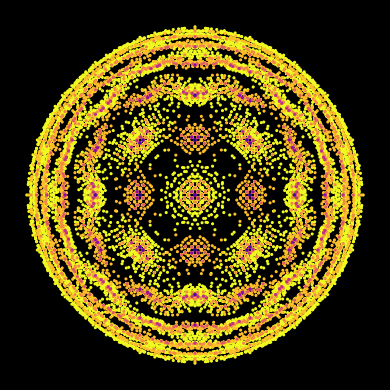

In [201]:
def update_beliefs(beliefs, T, ones):
    ones = ones.squeeze()
    numerator = torch.einsum('bf,eft->bet', beliefs, T)
    denominator = torch.einsum('bet,t->be', numerator, ones).unsqueeze(-1)
    new_beliefs = numerator / denominator
    return new_beliefs.view(-1, T.shape[1])


alpha = 1.
beta = 6.
gamma = 1./(2*np.sqrt(alpha**2+beta**2))
G = create_G_matrices(alpha, beta, gamma)
G_process = TransitionMatrixGHMM(G)
G_process.name = "G"
ones = torch.tensor(G_process.right_eigenvector, dtype=torch.float32, device=device)
pi = torch.tensor(G_process.steady_state_vector, dtype=torch.float32, device=device)
T = torch.tensor(G_process.transition_matrix, dtype=torch.float32, device=device)

beliefs = pi
depth = 8  # You can adjust this value as needed
all_beliefs = []
depths = []
for i in range(depth):
    beliefs = update_beliefs(beliefs, T, ones)
    all_beliefs.append(beliefs)
    num_beliefs = beliefs.shape[0]
    depths.append(np.full(num_beliefs, i))
# concatenate all_beliefs
all_beliefs = torch.cat(all_beliefs[::-1], dim=0).cpu().numpy() 
all_depths = np.concatenate(depths[::-1])
# scatter plot in 2d with black background and awesome colors
plt.figure(figsize=(4, 4), facecolor='black')
plt.style.use('dark_background')
ax = plt.gca()
scatter = ax.scatter(all_beliefs[:, 1], all_beliefs[:, 2], alpha=1, s=1.5, c=all_depths, cmap='plasma')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.axis('off')
plt.tight_layout()
plt.show()

In [188]:
depths

[0,
 array([0, 0, 0, 0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 

In [211]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
import torch
from tqdm.auto import tqdm

alpha = 1.
n_frames = 1000

# Function to update the beliefs
def update_beliefs(beliefs, T, ones):
    ones = ones.squeeze()
    numerator = torch.einsum('bf,eft->bet', beliefs, T)
    denominator = torch.einsum('bet,t->be', numerator, ones).unsqueeze(-1)
    new_beliefs = numerator / denominator
    return new_beliefs.view(-1, T.shape[1])

# Set device for torch tensors
device = torch.device('cpu' if torch.backends.mps.is_available() else 'cpu')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Function to update the plot for each frame
def update(frame):
    beta = np.linspace(1, 8, n_frames)[frame]
    gamma = 1 / (2 * np.sqrt(alpha**2 + beta**2))
    G = create_G_matrices(alpha, beta, gamma)
    
    G_process = TransitionMatrixGHMM(G)
    G_process.name = "G"

    # Convert to torch tensors
    ones = torch.tensor(G_process.right_eigenvector, dtype=torch.float32, device=device)
    pi = torch.tensor(G_process.steady_state_vector, dtype=torch.float32, device=device)
    T = torch.tensor(G_process.transition_matrix, dtype=torch.float32, device=device)
    
    # Initialize beliefs and compute over depth
    beliefs = pi
    depth = 8  # Adjust as needed
    all_beliefs = []
    depths = []
    for i in range(depth):
        beliefs = update_beliefs(beliefs, T, ones)
        all_beliefs.append(beliefs)
        num_beliefs = beliefs.shape[0]
        depths.append(np.full(num_beliefs, i))
    # Concatenate all beliefs and depths
    all_beliefs = torch.cat(all_beliefs[::-1], dim=0).cpu().numpy()
    all_depths = np.concatenate(depths[::-1])
    
    # Clear previous plot
    ax.clear()
    
    # Create the scatter plot
    distance_from_origin = np.sqrt(all_beliefs[:, 1]**2 + all_beliefs[:, 2]**2)
    scatter = ax.scatter(all_beliefs[:, 1], all_beliefs[:, 2], alpha=1, s=1.5,
                         c=1-distance_from_origin, cmap='plasma')
    
    # Set plot properties
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('black')
    
    # Add title
    ax.set_title(f'Beta: {beta:.2f}', color='white')

    return scatter,

# Create the animation with tqdm progress bar
pbar = tqdm(total=n_frames, desc="Generating frames")
def update_with_progress(frame):
    result = update(frame)
    pbar.update(1)
    return result

anim = FuncAnimation(fig, update_with_progress, frames=n_frames, interval=200, blit=True)

# Set figure properties
fig.patch.set_facecolor('black')

# Save as GIF
writer = PillowWriter(fps=20)
anim.save('quantum_animation2.gif', writer=writer)

plt.close(fig)
pbar.close()

print("Animation saved as 'quantum_animation2.gif'")


Generating frames:   0%|          | 0/1000 [00:00<?, ?it/s]

In [223]:
def update_beliefs_batched(beliefs, T, ones):
    """
    We are batching over hyperapams of the process here.
    beliefs is shape [hyperparam, belief, from state]
    T is shape [hyperparam, emission, from state, to state]
    ones is shape [hyperparam, to state]
    """
    
    print(beliefs.shape, T.shape, ones.shape)
    numerator = torch.einsum('hbf,heft->hbet', beliefs, T)
    denominator = torch.einsum('hbet,ht->hbe', numerator, ones).unsqueeze(-1)
    new_beliefs = numerator / denominator
    return new_beliefs.view(T.shape[0],-1, T.shape[2])

betas = np.linspace(1.2, 7, 10)
T_list = []
ones_list = []
pi_list = []
device = torch.device('cpu' if torch.backends.mps.is_available() else 'cpu')
for beta_index, beta in enumerate(betas):
    gamma = 1 / (2 * np.sqrt(alpha**2 + beta**2))
    G = create_G_matrices(alpha, beta, gamma)
    G_process = TransitionMatrixGHMM(G)
    G_process.name = "G"

    T_list.append(torch.tensor(G_process.transition_matrix, dtype=torch.float32, device=device))
    ones_list.append(torch.tensor(G_process.right_eigenvector.squeeze(), dtype=torch.float32, device=device))
    pi_list.append(torch.tensor(G_process.steady_state_vector, dtype=torch.float32, device=device))

T = torch.stack(T_list)
ones = torch.stack(ones_list)
pi = torch.stack(pi_list)




torch.Size([10, 1, 3]) torch.Size([10, 4, 3, 3]) torch.Size([10, 3])
torch.Size([10, 4, 3])
torch.Size([10, 4, 3]) torch.Size([10, 4, 3, 3]) torch.Size([10, 3])


/var/folders/gv/001yhxz1531ct7td9p0zgrh80000gn/T/ipykernel_76047/491784183.py:36: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored







Precomputing batch 0, frame 0
Precomputing batch 0, frame 0


Precomputing batch 0, frame 0
Precomputing batch 0, frame 0


Updating frame 1


Updating frame 2


Updating frame 3


Updating frame 4


Updating frame 5


Updating frame 6


Updating frame 7


Updating frame 8


Updating frame 9


Updating frame 10


Updating frame 11


Updating frame 12


Updating frame 13


Updating frame 14


Updating frame 15


Updating frame 16


Updating frame 17


Updating frame 18


Updating frame 19


Updating frame 20


Updating frame 21


Updating frame 22


Updating frame 23


Updating frame 24


Updating frame 25


Updating frame 26


Updating frame 27


KeyboardInterrupt: 

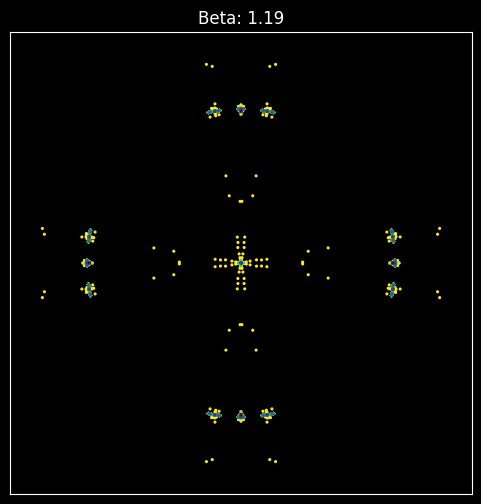

In [230]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
import torch
from tqdm import tqdm

alpha = 1.
n_frames = 1000

# Function to update the beliefs in batches
def update_beliefs_batched(beliefs, T, ones):
    """
    We are batching over hyperparams of the process here.
    beliefs is shape [batch_size, belief, from_state]
    T is shape [batch_size, emission, from_state, to_state]
    ones is shape [batch_size, to_state]
    """
    numerator = torch.einsum('hbf,heft->hbet', beliefs, T)
    denominator = torch.einsum('hbet,ht->hbe', numerator, ones).unsqueeze(-1)
    new_beliefs = numerator / denominator
    return new_beliefs.view(T.shape[0], -1, T.shape[2])

# Set device for torch tensors
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')

# Precompute beta values
beta_values = np.linspace(1, 8, n_frames)

# Define batch size (number of beta values to process at once)
batch_size = 100  # Adjust based on your system's memory capacity

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Initialize the scatter plot
scatter = ax.scatter([], [], alpha=1, s=1.5, cmap='plasma')

# Set plot properties
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('black')
ax.set_title('', color='white')

# Set figure properties
fig.patch.set_facecolor('black')

# Function to precompute G_processes for a batch of beta values
def precompute_G_processes(beta_batch):
    T_list = []
    ones_list = []
    pi_list = []
    for beta in beta_batch:
        gamma = 1 / (2 * np.sqrt(alpha**2 + beta**2))
        G = create_G_matrices(alpha, beta, gamma)
        G_process = TransitionMatrixGHMM(G)
        G_process.name = "G"

        T_list.append(torch.tensor(G_process.transition_matrix, dtype=torch.float32, device=device))
        ones_list.append(torch.tensor(G_process.right_eigenvector.squeeze(), dtype=torch.float32, device=device))
        pi_list.append(torch.tensor(G_process.steady_state_vector, dtype=torch.float32, device=device))
    T = torch.stack(T_list)
    ones = torch.stack(ones_list)
    pi = torch.stack(pi_list)
    return T, ones, pi

# Function to update the plot for each frame
def update(frame):
    # Determine the batch index and the index within the batch
    batch_index = frame // batch_size
    frame_in_batch = frame % batch_size

    # If it's the first frame in the batch, precompute the batch
    if frame_in_batch == 0:
        print(f"Precomputing batch {batch_index}, frame {frame_in_batch}")
        # Get beta values for this batch
        beta_batch = beta_values[batch_index * batch_size : (batch_index + 1) * batch_size]
        # Precompute T, ones, pi for this batch
        T_batch, ones_batch, pi_batch = precompute_G_processes(beta_batch)
        # Initialize beliefs for this batch
        beliefs_batch = pi_batch  # Shape: [batch_size, 1, num_states]
        depth = 8  # Adjust as needed
        all_beliefs_batch = []
        depths_batch = []
        for i in range(depth):
            beliefs_batch = update_beliefs_batched(beliefs_batch, T_batch, ones_batch)
            all_beliefs_batch.append(beliefs_batch)
            num_beliefs = beliefs_batch.shape[1]
            depths_batch.append(np.full((batch_size, num_beliefs), i))
        # Concatenate beliefs and depths
        all_beliefs_batch = torch.cat(all_beliefs_batch[::-1], dim=1).cpu().numpy()  # Shape: [batch_size, total_beliefs, num_states]
        all_depths_batch = np.concatenate(depths_batch[::-1], axis=1)  # Shape: [batch_size, total_beliefs]
        # Store the batch data for use in frames within the batch
        update.all_beliefs_batch = all_beliefs_batch
        update.all_depths_batch = all_depths_batch
        update.beta_batch = beta_batch
    else:
        print(f"Updating frame {frame_in_batch}")

    # Get the data for the current frame within the batch
    beliefs = update.all_beliefs_batch[frame_in_batch]  # Shape: [total_beliefs, num_states]
    depths = update.all_depths_batch[frame_in_batch]  # Shape: [total_beliefs]
    beta = update.beta_batch[frame_in_batch]

    # Update the scatter plot data
    scatter.set_offsets(beliefs[:, 1:3])  # Update x and y data
    scatter.set_array(depths)  # Update colors

    # Update title
    ax.set_title(f'Beta: {beta:.2f}', color='white')

    # Update progress bar
    update.pbar.update(1)

    return scatter,

# Initialize static variables for the update function
update.all_beliefs_batch = None
update.all_depths_batch = None
update.beta_batch = None

# Create progress bar
update.pbar = tqdm(total=n_frames, desc="Generating frames")

# Create the animation
anim = FuncAnimation(fig, update, frames=n_frames, interval=20, blit=True)

# Save as GIF
writer = PillowWriter(fps=20)
anim.save('quantum_animation3.gif', writer=writer)

plt.close(fig)
update.pbar.close()

print("Animation saved as 'quantum_animation3.gif'")
anim.save('quantum_animation3.gif', writer=writer)

plt.close(fig)

print("Animation saved as 'quantum_animation3.gif'")


In [246]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, FFMpegWriter
import torch
from tqdm.auto import tqdm
alpha = 1.
n_frames = 1000
# Create beta values that start slow and then accelerate
beta_start = 1.5
beta_end = 8.0
t = np.linspace(0, 1, n_frames)
beta_values = beta_start + (beta_end - beta_start) * (t ** 4)  # Quadratic easing

# Set device for torch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Precompute all data
depth = 8  # Adjust as needed
all_beliefs_frames = []
all_distances_frames = []
beta_frames = []

for frame in tqdm(range(n_frames), desc="Precomputing data"):
    beta = beta_values[frame]
    gamma = 1 / (2 * np.sqrt(alpha**2 + beta**2))
    G = create_G_matrices(alpha, beta, gamma)
    G_process = TransitionMatrixGHMM(G)
    G_process.name = "G"

    # Convert to torch tensors
    ones = torch.tensor(G_process.right_eigenvector.squeeze(), dtype=torch.float32, device=device)
    pi = torch.tensor(G_process.steady_state_vector, dtype=torch.float32, device=device)
    T = torch.tensor(G_process.transition_matrix, dtype=torch.float32, device=device)

    beliefs = pi.unsqueeze(0)
    all_beliefs = []
    for i in range(depth):
        beliefs = update_beliefs_batched(beliefs, T.unsqueeze(0), ones.unsqueeze(0))
        all_beliefs.append(beliefs)
    # Concatenate beliefs
    all_beliefs = torch.cat(all_beliefs[::-1], dim=1).cpu().numpy().squeeze(0)
    # Calculate distances from origin
    distances = 1-np.sqrt(np.sum(all_beliefs[:, 1:3]**2, axis=1))
    # Store for animation
    all_beliefs_frames.append(all_beliefs)
    all_distances_frames.append(distances)
    beta_frames.append(beta)

print("Precomputation complete")
# Now create the animation using the precomputed data
fig, ax = plt.subplots(figsize=(6, 6))
scatter = ax.scatter([], [], s=1.5, c=[], cmap='plasma', rasterized=True)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_aspect('equal')
ax.axis('off')
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

from tqdm.auto import tqdm

def update(frame):
    beliefs = all_beliefs_frames[frame]
    distances = all_distances_frames[frame]
    beta = beta_frames[frame]
    scatter.set_offsets(beliefs[:, 1:3])
    scatter.set_array(distances)
    ax.set_title(f'Beta: {beta:.2f}', color='white')
    pbar.update(1)
    return scatter,

pbar = tqdm(total=n_frames, desc="Generating animation")
anim = FuncAnimation(fig, update, frames=n_frames, interval=20, blit=False)

# Save as MP4
writer = FFMpegWriter(fps=40)
anim.save('quantum_animation.mp4', writer=writer)

plt.close(fig)
pbar.close()

print("Animation saved as 'quantum_animation.mp4'")


Precomputing data:   0%|          | 0/1000 [00:00<?, ?it/s]

Precomputation complete


Generating animation:   0%|          | 0/1000 [00:00<?, ?it/s]

Animation saved as 'quantum_animation.mp4'


In [249]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, FFMpegWriter
import torch
from tqdm.auto import tqdm
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, CustomJS
from bokeh.palettes import Plasma256
from bokeh.plotting import figure, output_file, show
from bokeh.transform import linear_cmap

alpha = 1.
n_frames = 1000
# Create beta values that start slow and then accelerate
beta_start = 1.5
beta_end = 8.0
t = np.linspace(0, 1, n_frames)
beta_values = beta_start + (beta_end - beta_start) * (t ** 4)  # Quadratic easing

# Set device for torch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Precompute all data
depth = 8  # Adjust as needed
all_beliefs_frames = []
all_distances_frames = []
beta_frames = []

for frame in tqdm(range(n_frames), desc="Precomputing data"):
    beta = beta_values[frame]
    gamma = 1 / (2 * np.sqrt(alpha**2 + beta**2))
    G = create_G_matrices(alpha, beta, gamma)
    G_process = TransitionMatrixGHMM(G)
    G_process.name = "G"

    # Convert to torch tensors
    ones = torch.tensor(G_process.right_eigenvector.squeeze(), dtype=torch.float32, device=device)
    pi = torch.tensor(G_process.steady_state_vector, dtype=torch.float32, device=device)
    T = torch.tensor(G_process.transition_matrix, dtype=torch.float32, device=device)

    beliefs = pi.unsqueeze(0)
    all_beliefs = []
    for i in range(depth):
        beliefs = update_beliefs_batched(beliefs, T.unsqueeze(0), ones.unsqueeze(0))
        all_beliefs.append(beliefs)
    # Concatenate beliefs
    all_beliefs = torch.cat(all_beliefs[::-1], dim=1).cpu().numpy().squeeze(0)
    # Calculate distances from origin
    distances = 1-np.sqrt(np.sum(all_beliefs[:, 1:3]**2, axis=1))
    # Store for animation
    all_beliefs_frames.append(all_beliefs)
    all_distances_frames.append(distances)
    beta_frames.append(beta)

print("Precomputation complete")
# Now create the animation using the precomputed data
# Prepare data for Bokeh
x = np.concatenate([beliefs[:, 1] for beliefs in all_beliefs_frames])
y = np.concatenate([beliefs[:, 2] for beliefs in all_beliefs_frames])
distances = np.concatenate(all_distances_frames)
frame = np.repeat(np.arange(n_frames), len(all_beliefs_frames[0]))

# Create ColumnDataSource
source = ColumnDataSource(data=dict(x=x, y=y, distance=distances, frame=frame))

# Create the figure
p = figure(width=600, height=600, x_range=(-0.5, 0.5), y_range=(-0.5, 0.5),
           title="Quantum Animation")
p.background_fill_color = "black"
p.border_fill_color = "black"
p.outline_line_color = None
p.axis.visible = False

# Add the scatter plot with a color mapper
color_mapper = linear_cmap(field_name='distance', palette=Plasma256, low=min(distances), high=max(distances))
scatter = p.scatter('x', 'y', source=source, size=2, color=color_mapper)

# Create a custom JavaScript callback for animation
callback = CustomJS(args=dict(source=source), code="""
    const data = source.data;
    const f = cb_obj.value;
    const n = data['x'].length / f;
    
    for (let i = 0; i < n; i++) {
        source.data['x'][i] = data['x'][i + f * n];
        source.data['y'][i] = data['y'][i + f * n];
        source.data['distance'][i] = data['distance'][i + f * n];
    }
    
    source.change.emit();
    
    const beta = beta_start + (beta_end - beta_start) * Math.pow(f / (n_frames - 1), 4);
    document.getElementById('beta-value').textContent = beta.toFixed(2);
""")

# Create a slider for manual control
from bokeh.models import Slider
slider = Slider(start=0, end=n_frames-1, value=0, step=1, title="Frame")
slider.js_on_change('value', callback)

# Add custom HTML for displaying beta value
from bokeh.models import Div
beta_display = Div(text="<p style='color: white;'>Beta: <span id='beta-value'>1.30</span></p>")

# Combine the plot and slider
layout = column(p, slider, beta_display)

# Output to static HTML file
output_file("quantum_animation.html")
show(layout)

print("Animation saved as 'quantum_animation.html'")


Precomputing data:   0%|          | 0/1000 [00:00<?, ?it/s]

Precomputation complete
Animation saved as 'quantum_animation.html'
